# Play with the measpy.Signal class

The ```measpy.signal.Signal``` class describes a sampled temporal signal which is described by the following properties:

- A sampling frequency ```fs```
- A physical unit ```unit```
- A calibration ```cal``` in unit per Volt (if the signal comes from an DAQ acquisition)
- A multiplicative constant ```dbfs``` which express the voltage amplitude for which the acquired data equals 1 (one). This is a classical quantity when acquiring signals with audio cards, but can be ignored and kept at 1.0 with most data acquisition cards.
- A numpy array ```_rawvalues```, which corresponds to the raw data given by the digital acquisition process.
- A description ```desc``` (a string that describes the signal)



In [2]:
import sys
sys.path.insert(0, "..")

import measpy as mp
import numpy as np

## 1. Basics

Let us create a signal S with a sampling frequency of 44100 Hz.

If ```unit```, ```calibration``` and ```dbfs``` are not specified they are defaulted to dimensionless, 1.0 and 1.0. And if no content is given the array ```_rawvalues``` doesn't exist and equals ```None```.

In [3]:
S = mp.Signal(fs=44100)
print(S)
print(S._rawvalues)

measpy.Signal(fs=44100, desc='A signal', cal=1.0, unit='dimensionless', dbfs=1.0)
None


Let us give some content to the signal, for instance a sinusoid at the frequency 100Hz of a duration 1 second.

In [4]:
S._rawvalues = np.sin(2*np.pi*100*np.arange(0,1,1/S.fs))
S.desc = 'A sinusoidal signal at 1000Hz'

The signal can now be plotted.

<AxesSubplot:xlabel='Time (s)'>

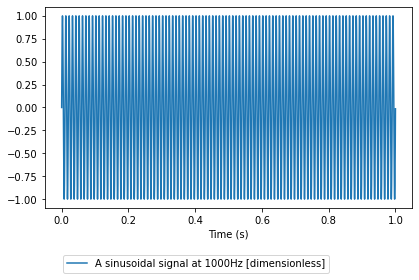

In [5]:
S.plot()

Note that this could have been done in one step at the initialization phase.

<AxesSubplot:xlabel='Time (s)'>

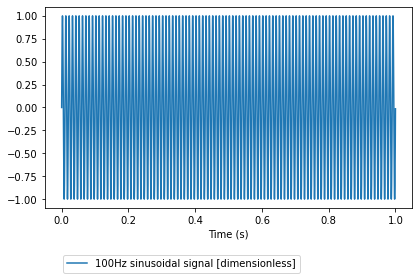

In [6]:
samplingfreq = 44100
S = mp.Signal(fs=samplingfreq,desc='100Hz sinusoidal signal',raw=np.sin(2*np.pi*100*np.arange(0,1,1/samplingfreq)))
S.plot()

There is a lot of additionnal properties for the signal. For instance, the duration and the time vector. These properties are not stored in memory. When asked for, they are calculated based on the number of samples in the signal. 

In [7]:
print(S.time)
print(S.dur)

[0.00000000e+00 2.26762512e-05 4.53525023e-05 ... 9.99954647e-01
 9.99977324e-01 1.00000000e+00]
1.0


## 2. Units

Let us now give a unit to this signal. Consider it is a velocity, in meter per second.

In [8]:
velsig = mp.Signal(fs=samplingfreq,desc='100Hz sinusoidal velocity',raw=np.sin(2*np.pi*100*np.arange(0,1,1/samplingfreq)),unit='m/s')

Consider a second signal, for instance a force in Newtons (N), in phase with the velocity.

In [9]:
forcesig = mp.Signal(fs=samplingfreq,desc='100Hz sinusoidal force',raw=np.sin(2*np.pi*100*np.arange(0,1,1/samplingfreq)),unit='N')

These to signal can be multiplied together, giving an instantaneous power!

<AxesSubplot:xlabel='Time (s)'>

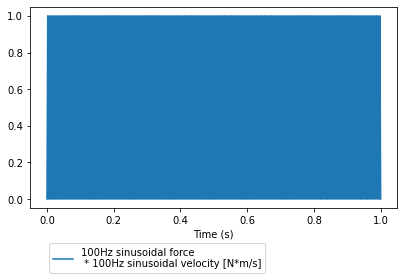

In [10]:
power = forcesig * velsig
power.plot()

Note that by default, the units are simply multiplied together. It it howver possible to ask for a standard unit for this signal. The below command will convert the signal to the standard unit for power (which is Watt)

In [11]:
power = power.unit_to_std()
print(power)

measpy.Signal(fs=44100, desc='100Hz sinusoidal force
 * 100Hz sinusoidal velocity
 -->Unit to W', cal=1.0, unit='W', dbfs=1.0)


The ```similar``` method makes a copy of the Signal object and modifies its properties specified in its arguments. Using this method, we can do the same as before and change the description at the same time.

In [12]:
power = (velsig*forcesig).unit_to_std().similar(desc='The power given to the system')
print(power)

measpy.Signal(fs=44100, desc='The power given to the system', cal=1.0, unit='W', dbfs=1.0)


We cannot add signal with incompatible dimensions.

In [13]:
forcesig+velsig

Exception: Incompatible units in addition of sginals

Added signals can have different dimensions, but compatible. Let us create a signal in meter, a signal in decameter, and add them.

<AxesSubplot:xlabel='Time (s)'>

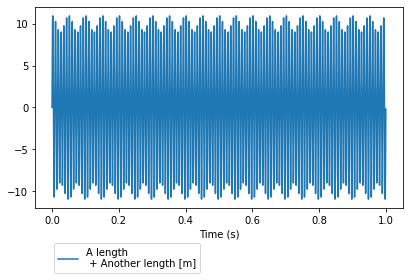

In [14]:
distance1 = mp.Signal(fs=samplingfreq,desc='A length',raw=np.sin(2*np.pi*100*np.arange(0,1,1/samplingfreq)),unit='m')
distance2 = mp.Signal(fs=samplingfreq,desc='Another length',raw=np.sin(2*np.pi*120*np.arange(0,1,1/samplingfreq)),unit='dam')
distancetot = distance1+distance2
distancetot.plot()

The final unit is that of the first operand. Hence if we switch the signals, we get the same thing, but in decameters...

<AxesSubplot:xlabel='Time (s)'>

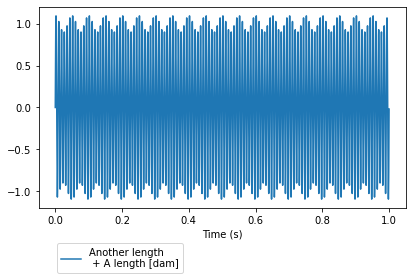

In [15]:
distancetot = distance2+distance1
distancetot.plot()

We might want to convert this to millimeters...

<AxesSubplot:xlabel='Time (s)'>

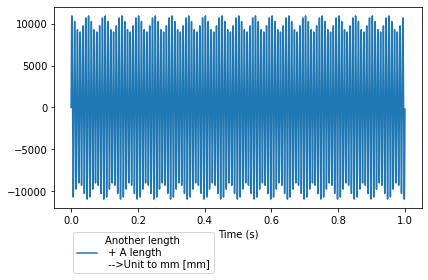

In [16]:
distancetot.unit_to('mm').plot()

## 3. Calibrations

Up to now, we didn't care about calibration. In fact, if we worked only with such synthesized signal, there wouldn't be any reason to.

Most of the time, these signals come from data acquisition process, where an accelerometer, a force/torque sensor, a microphone or an optical velocity measurement device is involved.

Conditionners generally produce a voltage signal that is proportionnal to the measured quantity. The calibration ```cal``` is hence a float number which in expressed in Volts/units.

The data acquisition device the captures this voltage signal at a given sampling frequency. If the acquired samples directly express the voltage input, ```dbfs=1```. With some devices (generally line inputs of sound cards), the acquired sample values are proportionnal, but not equal. The coefficient of proportionnality is ```dbfs```.

The true signal expressed in unit is hence given by multiplying the ```_rawvalues``` property by dbfs (to convert it in volts) and dividing the resulting array by ```cal```.

There are methods for that.


Consider the signal below. A sinusoidal velocity. The calibration was 2V/(m/s) and the input measures 1.0 when there is 5 incoming Volts.

In [17]:
velsig = mp.Signal(fs=samplingfreq,
    desc='100Hz sinusoidal velocity',
    raw=np.sin(2*np.pi*100*np.arange(0,1,1/samplingfreq)),
    unit='m/s',
    cal=2.0,
    dbfs=5.0)

The raw acquired values are accessed by using the ```_rawvalues``` properties (or ```raw```, which is a shortcut).

In [18]:
velsig.raw

array([ 0.        ,  0.0142471 ,  0.02849132, ..., -0.04272974,
       -0.02849132, -0.0142471 ])

We might want for some reason the actual voltage that was going into the daq card.

In [19]:
velsig.volts

array([ 0.        ,  0.07123552,  0.14245658, ..., -0.21364872,
       -0.14245658, -0.07123552])

The measured values in m/s are accessed using the ```values``` property... An this is what is plotted when we use the ```velsig.plot()``` method.

<AxesSubplot:xlabel='Time (s)'>

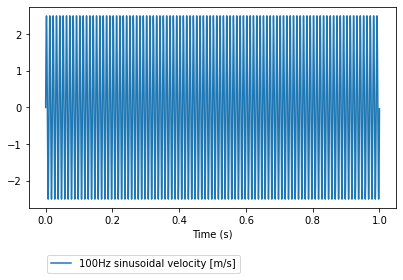

In [21]:
velsig.values
velsig.plot()